In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#set ranges for search years
start_range = np.arange(1982, 2015, 2)
end_range = np.arange(1983, 2016, 2)

In [3]:
#set empty list to hold tables
df_list = []

#loop over lotto tables
for i, j in zip(start_range, end_range):
    #read table
    table = pd.read_html(f'http://www.lotto649stats.com/winning-numbers-{i}-{j}.html')
    #create df and extract dates
    df = pd.DataFrame(table[0])
    df = df.iloc[4:,].iloc[:,:8]
    #add each df to holding list
    df_list.append(df)
    
#concat list together, drop NA's and rename Date column
df_master = pd.concat(df_list)
df_past = df_master.dropna(axis=0).rename(columns={0:'Date'}).copy()

In [4]:
def get_current():
    #returns current lotto results in dataframe
    #grab table
    table = pd.read_html('http://www.lotto649stats.com/recent_winning.html')
    #extract just the information we want
    df = pd.DataFrame(table[0])
    df = df.iloc[4:,].iloc[:,:8]
    print(df.head(5))
    #reverse the order, replace column with date
    df = df.iloc[::-1,:].reset_index().drop('index', axis=1)
    df = df.dropna(axis=0).rename(columns={0:'Date'})
    print(df.head(5))
    #return df as a variable
    return df

#create df variable
df_current = get_current()

                    0   1   2   3   4   5   6   7
4     October 3, 2018  15  32  38  40  44  45   2
5  September 29, 2018   1   6   7  10  31  49  39
6  September 26, 2018   5   7   9  35  42  45  31
7  September 22, 2018  19  34  36  39  40  49   2
8  September 19, 2018   3   9  15  17  23  45  18
               Date   1   2   3   4   5   6   7
0   October 7, 2015   4  10  19  31  38  43   5
1  October 10, 2015   8  12  22  27  35  41  16
2  October 14, 2015  23  31  32  34  35  44  10
3  October 17, 2015   4   5   6  22  29  30  20
4  October 21, 2015   8  17  22  33  40  49  27


In [20]:
#create final dataframe with everything
df_final = df_past.append(df_current, ignore_index=True)
#create file in directory
#df_final.to_csv('lotto_final_03_10_18.csv')

In [21]:
#create day number - Saturday = 0, Wednesday = 1
df_final['temp_date'] = pd.to_datetime(df_final['Date'])
df_final['day_rank'] = df_final['temp_date'].dt.day_name()
df_final['day'] = np.where(df_final['day_rank'] == 'Saturday', 0, 1)
df_final['day_of_month'] = df_final['temp_date'].apply(lambda x: x.day)
df_final = df_final.drop(['Date', 'temp_date', 'day_rank'], axis=1)

In [22]:
df_final.head(5)

,1,2,3,4,5,6,7,day,day_of_month
0,11,18,22,28,35,37,42,0,25
1,7,13,23,32,33,45,36,0,18
2,4,9,10,11,43,46,3,0,11
3,6,17,24,36,38,46,29,0,4
4,5,17,21,28,30,43,36,0,27


In [38]:
""" y = 1..2..3...7 
    x = """
df_final.columns

Index([1, 2, 3, 4, 5, 6, 7, 'day', 'day_of_month'], dtype='object')

In [50]:
y_one = df_final[1]
x_one = df_final.copy()
x_one = x_one.drop(1, axis=1)

In [59]:
x_one['one'] = y_one - df_final[2]
x_one

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [47]:
#split the training and test data
X_train, X_test, y_train, y_test = train_test_split(x_one, y_one, test_size=0.2)

In [23]:
from scipy import stats
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

Run a separate classification on each feature 

In [34]:
df_final.head()

,1,2,3,4,5,6,7,day,day_of_month
0,11,18,22,28,35,37,42,0,25
1,7,13,23,32,33,45,36,0,18
2,4,9,10,11,43,46,3,0,11
3,6,17,24,36,38,46,29,0,4
4,5,17,21,28,30,43,36,0,27


In [25]:
#model #1
# set features
X_ = df_final.drop('day_of_month', axis=1)
# set independent variable
y = df_final['day_of_month']
#split the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

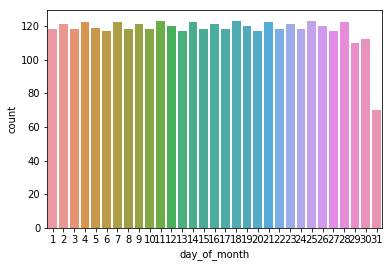

In [48]:
sns.countplot(y)

In [49]:
#fit log model to data
log_model = linear_model.LogisticRegression()
log_model.fit(X_train, y_train)
print('The normalized training accuracy is: {}%'.format(log_model.score(X_train, y_train)))
print('The normalized test accuracy is: {}%'.format(log_model.score(X_test, y_test)))

/Users/BMO/Desktop/Dairshine/py3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/BMO/Desktop/Dairshine/py3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The normalized training accuracy is: 0.1361454046639232%
The normalized test accuracy is: 0.11917808219178082%


In [355]:
#test out different SVMs using the different kernals
kerns = ['linear', 'rbf', 'sigmoid']
for i in kerns:
    #Kernel trick
    svm = SVC(C=0.01, kernel='{}'.format(i))
    svm.fit(X_train,y_train)
    
    #Get the score
    print('{0} Kernal SVM score: {1}'.format(i, (100*svm.score(X_test,y_test))))

linear Kernal SVM score: 3.5648994515539303
rbf Kernal SVM score: 2.83363802559415
sigmoid Kernal SVM score: 2.376599634369287


In [29]:
#testing out random forest  
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
print("Default RFR: %3.3f" % (rf.score(X_test, y_test)))

Default RFR: 0.045


In [28]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import GradientBoostingClassifier

gb =GradientBoostingClassifier()
gb.fit(X_train,y_train)

xgb = XGBClassifier()
xgb.fit(X_train,y_train)

print("Gradient Boost score: %3.3f" % (100 * gb.score(X_test,y_test)))
print("XG Boost score: %3.3f"       % (100 * xgb.score(X_test,y_test)))

TypeError: sequence item 0: expected str instance, int found

In [32]:
from scipy import stats

y_predict = rf.predict(X_train)
stats.describe(y_predict)

DescribeResult(nobs=2916, minmax=(1, 31), mean=15.62002743484225, variance=77.39244953612528, skewness=0.028455198642962715, kurtosis=-1.191868516122025)

In [33]:
from sklearn.ensemble import VotingClassifier

KNN_model = KNeighborsClassifier()
SVM_model_one = SVC(kernel = 'linear', probability=True)
SVM_model_two = SVC(kernel = 'rbf', probability=True)

#Build the ensemble
ensemble = VotingClassifier(estimators=[('KNN Model', KNN_model),\
                                        ('SVM Model Linear', SVM_model_one),\
                                        ('SVM Model RBF', SVM_model_two)],\
                                        voting="hard",\
                                        weights = [1,1,1])

ensemble.fit(X_train, y_train)
ensemble.score(X_test, y_test)

/Users/BMO/Desktop/Dairshine/py3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.030136986301369864